# Classification Maps

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import xarray as xr
import xoak
from svrimg.utils.get_tables import get_table
from svrimg.utils.get_images import get_img_list
import cartopy
import cartopy.crs as ccrs

In [2]:
#open dummy xarray dataset
ds = xr.open_dataset('/home/scratch/WRF_BCC/severe_weather/UP_HELI_MAX/historical/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc').sel(Time='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()

#load the geog file produce for WRF-BCC
geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")

#merge the datasets
ds_geog = xr.merge([ds, geog.squeeze()])
ds_geog = ds_geog.rename({"CLONG": 'lon', 'CLAT': 'lat'})

#assign lat/lon values of coarsen data and set index
ds_geog = ds_geog.assign_coords({'x': ds_geog.west_east, 'y': ds_geog.south_north})
ds_geog = ds_geog.assign_coords({'lon': ds_geog.lon, 'lat': ds_geog.lat})
ds_geog.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')

In [3]:
#load the classification labels
df = pd.read_csv('/home/jcorner1/SVRIMG/data/tor/classifications_101623.csv')
df

,UNID,Class Code,Class Name
0,199601030010z000000859,0,isolated_cell
1,199601030020z000000860,0,isolated_cell
2,199605022300z000000295,0,isolated_cell
3,199605150140z000000715,0,isolated_cell
4,199605160408z000000190,0,isolated_cell
...,...,...,...
5784,201710082137z000615804,5,tropical
5785,201710082140z000615805,5,tropical
5786,201710082151z000615806,5,tropical
5787,201710082201z000615807,5,tropical


In [4]:
#download tables and images from SVRIMG
df_not_subset = get_table(which='svrimg', haz_type='tor', data_dir="/home/jcorner1/SVRIMG/data/CSVs")
df_not_subset.ymin

unid
199601011725z000000001    112
199601030010z000000859    270
199601030020z000000860    270
199601031307z000000004     41
199601031340z000000005     52
                         ... 
201712200759z000615894    141
201712200817z000615895    143
201712201239z000615896    174
201712201640z000615897    242
201712201815z000615898    241
Name: ymin, Length: 27052, dtype: int64

In [5]:
#join the SVRIMG csv with the classification csv
df = df.set_index(df["UNID"])

In [6]:
df_join = df.join(df_not_subset)

new_name = []
new_code = []

for rid, row in df_join.iterrows():
    if row['Class Code'] == 0 or row['Class Code'] == 1:
        new_name.append('Cellular')
        new_code.append(0)
        
    elif row['Class Code'] == 2 or row['Class Code'] == 3:
        new_name.append('Mixed Mode')
        new_code.append(1)
        
    elif row['Class Code'] == 4:
        new_name.append('Linear')
        new_code.append(2)
    
    elif row['Class Code'] == 5:
        new_name.append('Other')
        new_code.append(3)
        

df_join['New Code'] = new_code
df_join['New Name'] = new_name

df_join

,UNID,Class Code,Class Name,area,convection_area,filename,intense_area,intensity_variance,kind,max_intensity,mean_intensity,radar_file,radar_time,report_time,xmax,xmin,ymax,ymin,New Code,New Name
UNID,,,,,,,,,,,,,,,,,,,,
199601030010z000000859,199601030010z000000859,0,isolated_cell,12150.0000,998.4375,/data/haberlie/report_boxes_gridrad/tor/1996/0...,182.8125,120.341792,tor,60,2.448692,/data/haberlie/sim_4k_interp/GRIDRAD_MAXREFC/1...,1/3/1996 0:00,1/3/1996 0:10,1176,1041,405,270,0,Cellular
199601030020z000000860,199601030020z000000860,0,isolated_cell,12079.6875,998.4375,/data/haberlie/report_boxes_gridrad/tor/1996/0...,182.8125,120.944422,tor,60,2.425011,/data/haberlie/sim_4k_interp/GRIDRAD_MAXREFC/1...,1/3/1996 0:00,1/3/1996 0:20,1177,1042,405,270,0,Cellular
199605022300z000000295,199605022300z000000295,0,isolated_cell,26606.2500,168.7500,/data/haberlie/report_boxes_gridrad/tor/1996/0...,28.1250,102.806528,tor,54,4.554715,/data/haberlie/sim_4k_interp/GRIDRAD_MAXREFC/1...,5/2/1996 23:00,5/2/1996 23:00,791,656,670,535,0,Cellular
199605150140z000000715,199605150140z000000715,0,isolated_cell,11137.5000,506.2500,/data/haberlie/report_boxes_gridrad/tor/1996/0...,84.3750,58.449095,tor,52,3.661711,/data/haberlie/sim_4k_interp/GRIDRAD_MAXREFC/1...,5/15/1996 2:00,5/15/1996 1:40,721,586,407,272,0,Cellular
199605160408z000000190,199605160408z000000190,0,isolated_cell,19673.4375,1603.1250,/data/haberlie/report_boxes_gridrad/tor/1996/0...,660.9375,70.396541,tor,65,5.541414,/data/haberlie/sim_4k_interp/GRIDRAD_MAXREFC/1...,5/16/1996 4:00,5/16/1996 4:08,673,538,619,484,0,Cellular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201710082137z000615804,201710082137z000615804,5,tropical,116634.3750,2812.5000,/data/haberlie/report_boxes_gridrad/tor/2017/1...,0.0000,98.966033,tor,49,16.884299,/data/haberlie/sim_4k_interp/GRIDRAD_MAXREFC/2...,10/8/2017 22:00,10/8/2017 21:37,1135,1000,448,313,3,Other
201710082140z000615805,201710082140z000615805,5,tropical,117028.1250,2798.4375,/data/haberlie/report_boxes_gridrad/tor/2017/1...,0.0000,98.147275,tor,49,16.938203,/data/haberlie/sim_4k_interp/GRIDRAD_MAXREFC/2...,10/8/2017 22:00,10/8/2017 21:40,1135,1000,449,314,3,Other
201710082151z000615806,201710082151z000615806,5,tropical,114848.4375,2840.6250,/data/haberlie/report_boxes_gridrad/tor/2017/1...,0.0000,95.196858,tor,49,16.352076,/data/haberlie/sim_4k_interp/GRIDRAD_MAXREFC/2...,10/8/2017 22:00,10/8/2017 21:51,1149,1014,469,334,3,Other


In [7]:
df_join['x_cent'] = ((df_join['xmax'] + df_join['xmin']+1)/2).astype(int)
df_join['y_cent'] = ((df_join['ymax'] + df_join['ymin'])/2).astype(int)

In [8]:
#create an array of zeros
zeros = np.zeros((ds_geog.lat.values.shape))

for i in range(4):
    df = df_join[(df_join['New Code'] == i)]

    for rid, row in df.iterrows():
        zeros[row.y_cent, row.x_cent] = zeros[row.y_cent, row.x_cent] + 1

    ds_mode = ds_geog.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))
    geog_cor = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()

    ds_mode = ds_mode.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    locals()[f'ds_mode{i}'] = xr.merge([ds_mode, geog_cor.squeeze()])


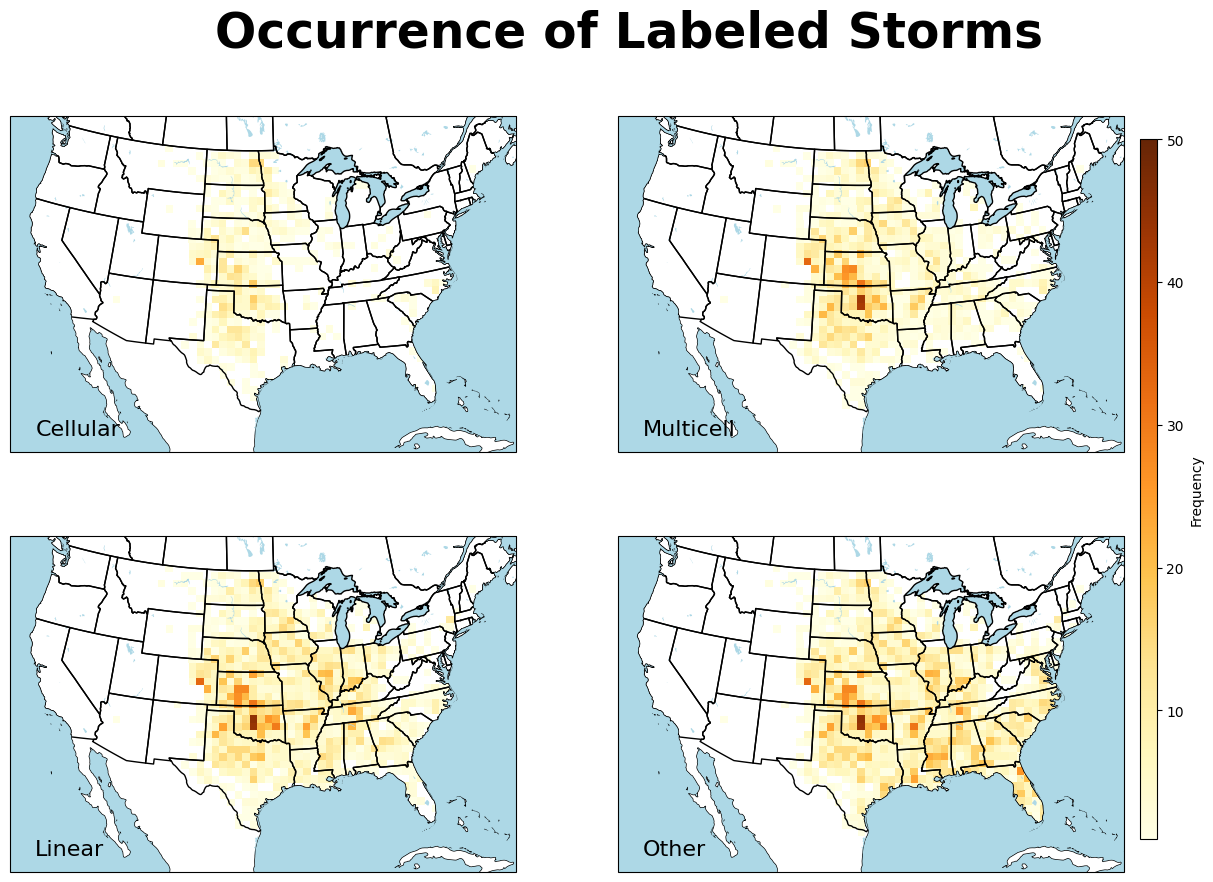

In [22]:
fig = plt.figure(figsize=(16.5,10))
plt.suptitle('Occurrence of Labeled Storms', size=35).set_weight('bold')
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])
plt.subplots_adjust(right=0.8)

for i in range(4):
    ax = plt.subplot(2,2,i+1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

    data = locals()[f'ds_mode{i}'].UP_HELI_MAX.values
    data[data==0] = np.nan

    c = ax.pcolormesh(ds_mode.lon.values, ds_mode.lat.values, data, transform=cartopy.crs.PlateCarree(), cmap='YlOrBr', vmax=50)

    ax.add_feature(cartopy.feature.STATES, zorder=2)
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.LAND, facecolor='white')
    ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=2)
    ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

    ax.set_extent([-120, -74, 20, 50])
    ax.annotate(['Cellular', 'Multicell', 'Linear', 'Other'][i], (0.05,0.05),fontsize=16, xycoords='axes fraction')


cbar = plt.colorbar(c, pad=0.01, ax=ax, cax=cbar_ax, ticks=list(range(0, 51, 10)))
cbar.ax.tick_params(labelsize=15)
#cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='upper', ticks=list(range(0, 60, 10)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)
plt.savefig('/home/jcorner1/Future_Modes/Plots/Labeled_occurrence.png', format='png', dpi=500, bbox_inches='tight')